<h2 align="center">"When communicating results to nontechnical types, there is nothing better than a clear visualization to make your point."</h2>
<h3 align="center">—John Tukey</h3>

# Challenge: Factors that affect life expectancy


Throughout this module, we dove deep into the topics of exploratory data analysis (EDA) and its substeps. Now it's time to apply your knowledge. In this challenge, you'll work with the [Life Expectancy dataset](https://www.kaggle.com/kumarajarshi/life-expectancy-who) from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

You should access the data from the Thinkful database. Here's the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'<br>
postgres_pw = '7\*.8G9QH21'<br>
postgres_host = '142.93.121.174'<br>
postgres_port = '5432'<br>
postgres_db = 'lifeexpectancy'<br>
table_name = 'lifeexpectancy'<br>

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks. Moreover, you can also submit a kernel to the Kaggle containing your solutions.

* Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

* First, load the dataset.

* Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them. 

* Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

* In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

* Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

#### First, load the dataset

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_expectancy = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
life_expectancy.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [4]:
life_expectancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [5]:
life_expectancy.columns = ['country', 'year','status','life_expectancy','adult_mortality','infant_deaths','alcohol','pct_expenditure',
                          'hepatitus_B','measles','BMI','under_five_deaths','polio','total_expenditure','diphtheria','HIV/AIDS',
                          'GDP','population','thinness_1-19_years','thinness_5-9_years','income_composition_resources','schooling']

#### Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

In [6]:
life_expectancy.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,pct_expenditure,hepatitus_B,measles,BMI,under_five_deaths,polio,total_expenditure,diphtheria,HIV/AIDS,GDP,population,thinness_1-19_years,thinness_5-9_years,income_composition_resources,schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


There are various issues with the data observable. 1) the bottom quartile of infant_deaths might have 0 data collection 2) same issue for measles 3) there are also a lot of missing values for some columns such as GDP and population

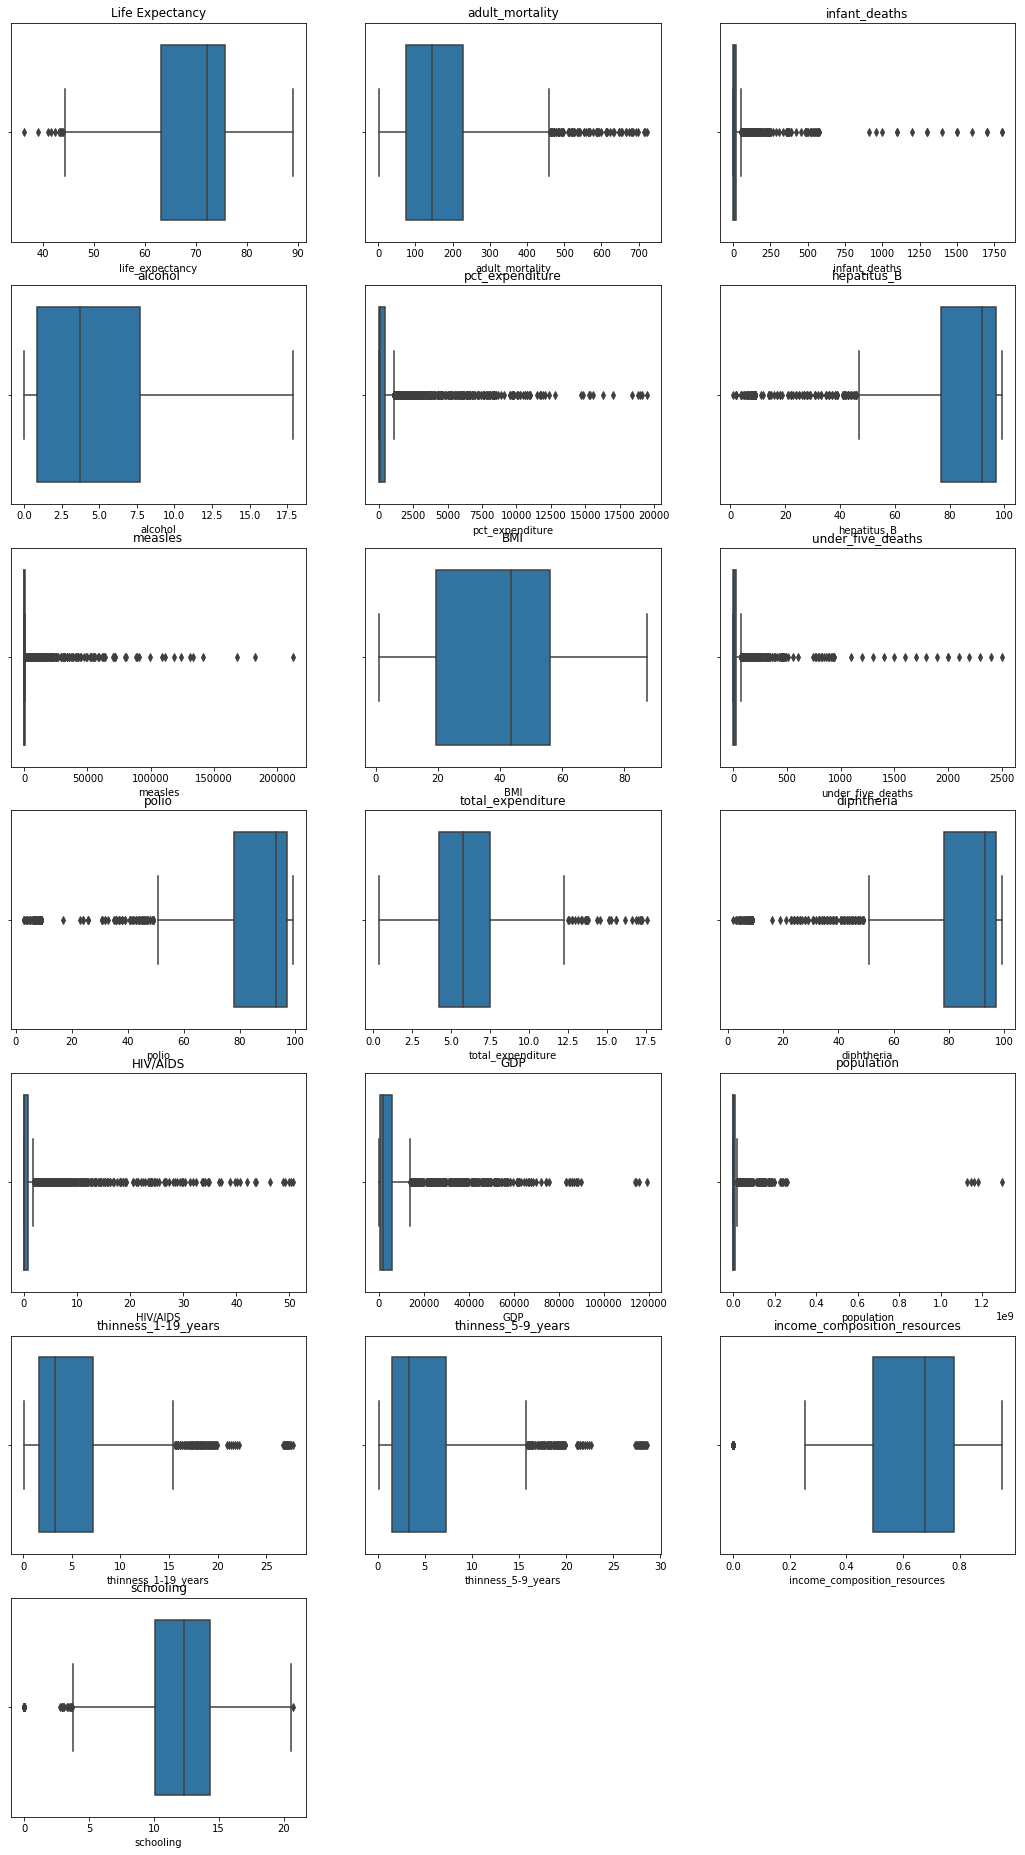

In [7]:
plt.figure(figsize=(18,33))

plt.subplot(7,3,1)
sns.boxplot(life_expectancy['life_expectancy'])
plt.title('Life Expectancy')

plt.subplot(7,3,2)
sns.boxplot(life_expectancy['adult_mortality'])
plt.title('adult_mortality')

plt.subplot(7,3,3)
sns.boxplot(life_expectancy['infant_deaths'])
plt.title('infant_deaths')

plt.subplot(7,3,4)
sns.boxplot(life_expectancy['alcohol'])
plt.title('alcohol')

plt.subplot(7,3,5)
sns.boxplot(life_expectancy['pct_expenditure'])
plt.title('pct_expenditure')

plt.subplot(7,3,6)
sns.boxplot(life_expectancy['hepatitus_B'])
plt.title('hepatitus_B')

plt.subplot(7,3,7)
sns.boxplot(life_expectancy['measles'])
plt.title('measles')

plt.subplot(7,3,8)
sns.boxplot(life_expectancy['BMI'])
plt.title('BMI')

plt.subplot(7,3,9)
sns.boxplot(life_expectancy['under_five_deaths'])
plt.title('under_five_deaths')

plt.subplot(7,3,10)
sns.boxplot(life_expectancy['polio'])
plt.title('polio')

plt.subplot(7,3,11)
sns.boxplot(life_expectancy['total_expenditure'])
plt.title('total_expenditure')

plt.subplot(7,3,12)
sns.boxplot(life_expectancy['diphtheria'])
plt.title('diphtheria')

plt.subplot(7,3,13)
sns.boxplot(life_expectancy['HIV/AIDS'])
plt.title('HIV/AIDS')

plt.subplot(7,3,14)
sns.boxplot(life_expectancy['GDP'])
plt.title('GDP')

plt.subplot(7,3,15)
sns.boxplot(life_expectancy['population'])
plt.title('population')

plt.subplot(7,3,16)
sns.boxplot(life_expectancy['thinness_1-19_years'])
plt.title('thinness_1-19_years')

plt.subplot(7,3,17)
sns.boxplot(life_expectancy['thinness_5-9_years'])
plt.title('thinness_5-9_years')

plt.subplot(7,3,18)
sns.boxplot(life_expectancy['income_composition_resources'])
plt.title('income_composition_resources')

plt.subplot(7,3,19)
sns.boxplot(life_expectancy['schooling'])
plt.title('schooling')

plt.show()

There are many outliers throughout the dataframe (infant_deaths, pct_expenditure, hep-B, lets run a z-score on some of the fields to see a different perspective, we will use a threshold of range of 2-4

In [8]:
from scipy.stats import zscore

cols = ['adult_mortality','infant_deaths','pct_expenditure','hepatitus_B','measles','under_five_deaths','polio',
       'total_expenditure','diphtheria','HIV/AIDS','GDP','population','thinness_1-19_years','thinness_5-9_years']

for col in cols:
    z_scores = zscore(life_expectancy[cols])
    for threshold in range(3,5): 
        print("for {} in life_expectancy:".format(col))
        print("The score threshold is: {}".format(threshold))
        print("The indices of the outliers:")
        print(np.where(z_scores > threshold))
        print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


for adult_mortality in life_expectancy:
The score threshold is: 3
The indices of the outliers:
(array([ 114,  115,  116,  117,  118,  119,  120,  130,  132,  133,  134,
        135,  136,  137,  242,  248,  347,  348,  349,  350,  351,  352,
        407,  498,  499,  501,  503,  504,  560,  561,  565,  566,  567,
        568,  569,  570,  571,  572,  572,  573,  573,  574,  574,  574,
        575,  575,  575,  723,  724,  725,  729,  730,  731,  732,  738,
        739,  741,  743,  744,  745,  747,  748,  932,  938, 1000, 1001,
       1002, 1003, 1172, 1174, 1178, 1179, 1181, 1182, 1187, 1187, 1187,
       1188, 1188, 1188, 1189, 1189, 1190, 1190, 1191, 1191, 1192, 1192,
       1193, 1193, 1193, 1194, 1194, 1194, 1195, 1195, 1195, 1196, 1196,
       1196, 1197, 1197, 1198, 1198, 1198, 1199, 1199, 1199, 1200, 1200,
       1200, 1201, 1201, 1201, 1202, 1202, 1202, 1257, 1258, 1259, 1260,
       1262, 1319, 1322, 1325, 1326, 1378, 1481, 1482, 1483, 1484, 1485,
       1486, 1487, 1488, 148

In [9]:
life_expectancy.isnull().sum()*100/life_expectancy.count()

country                          0.000000
year                             0.000000
status                           0.000000
life_expectancy                  0.341530
adult_mortality                  0.341530
infant_deaths                    0.000000
alcohol                          7.069971
pct_expenditure                  0.000000
hepatitus_B                     23.186583
measles                          0.000000
BMI                              1.170799
under_five_deaths                0.000000
polio                            0.650908
total_expenditure                8.333333
diphtheria                       0.650908
HIV/AIDS                         0.000000
GDP                             17.991968
population                      28.521435
thinness_1-19_years              1.170799
thinness_5-9_years               1.170799
income_composition_resources     6.026705
schooling                        5.873874
dtype: float64

We are missing a significant amount of data in a few of the features that may impact life expectancy. Lets use interpolation to clean up some of these missing values

In [10]:
fill_list = ['life_expectancy','adult_mortality','alcohol','hepatitus_B','BMI','polio', 'total_expenditure',
            'diphtheria','GDP','population','thinness_1-19_years','thinness_5-9_years', 'income_composition_resources',
            'schooling']

countries = life_expectancy["country"].unique()

for country in countries:
    life_expectancy.loc[life_expectancy["country"] == country, fill_list] = life_expectancy.loc[life_expectancy["country"] == country, fill_list].interpolate(limit_direction='both')


In [11]:
life_expectancy.isnull().sum()*100/life_expectancy.count()

country                          0.000000
year                             0.000000
status                           0.000000
life_expectancy                  0.341530
adult_mortality                  0.341530
infant_deaths                    0.000000
alcohol                          0.581992
pct_expenditure                  0.000000
hepatitus_B                      5.153901
measles                          0.000000
BMI                              1.170799
under_five_deaths                0.000000
polio                            0.000000
total_expenditure                1.101170
diphtheria                       0.000000
HIV/AIDS                         0.000000
GDP                             15.988946
population                      28.296943
thinness_1-19_years              1.170799
thinness_5-9_years               1.170799
income_composition_resources     6.026705
schooling                        5.873874
dtype: float64

In [12]:
print('Null values by variable:')
print('------------------------')
life_expectancy.isnull().sum()

Null values by variable:
------------------------


country                           0
year                              0
status                            0
life_expectancy                  10
adult_mortality                  10
infant_deaths                     0
alcohol                          17
pct_expenditure                   0
hepatitus_B                     144
measles                           0
BMI                              34
under_five_deaths                 0
polio                             0
total_expenditure                32
diphtheria                        0
HIV/AIDS                          0
GDP                             405
population                      648
thinness_1-19_years              34
thinness_5-9_years               34
income_composition_resources    167
schooling                       163
dtype: int64

We are still missing a lot of valuable information, rather than dropping the data lets impute missing values using the nearest features

In [13]:
life_expectancy2 = life_expectancy.copy()

fill_le = life_expectancy2[['year','life_expectancy','adult_mortality','infant_deaths','alcohol','pct_expenditure','hepatitus_B','measles','BMI','under_five_deaths','polio', 'total_expenditure',
            'diphtheria','HIV/AIDS','GDP','population','thinness_1-19_years','thinness_5-9_years', 'income_composition_resources',
            'schooling']]

from fancyimpute import IterativeImputer

imp = IterativeImputer(missing_values=np.nan, sample_posterior=False, 
                                 max_iter=10, tol=0.001, 
                                 n_nearest_features=4, initial_strategy='mean')
imp.fit(fill_le)
life_expectancy_fill = pd.DataFrame(data=imp.transform(fill_le), 
                             columns=['year','life_expectancy','adult_mortality','infant_deaths','alcohol','pct_expenditure','hepatitus_B','measles','BMI','under_five_deaths','polio', 'total_expenditure',
            'diphtheria','HIV/AIDS','GDP','population','thinness_1-19_years','thinness_5-9_years', 'income_composition_resources',
            'schooling'],
                             dtype='int')

Using TensorFlow backend.


Combine separated data frames

In [14]:
life_expectancy3 = pd.concat([life_expectancy['country'],life_expectancy['status'],life_expectancy_fill], axis=1)


In [15]:
life_expectancy3.head()

,country,status,year,life_expectancy,adult_mortality,infant_deaths,alcohol,pct_expenditure,hepatitus_B,measles,...,polio,total_expenditure,diphtheria,HIV/AIDS,GDP,population,thinness_1-19_years,thinness_5-9_years,income_composition_resources,schooling
0,Afghanistan,Developing,2015,65,263,62,0,71,65,1154,...,6,8,65,0,584,33736494,17,17,0,10
1,Afghanistan,Developing,2014,59,271,64,0,73,62,492,...,58,8,62,0,612,327582,17,17,0,10
2,Afghanistan,Developing,2013,59,268,66,0,73,64,430,...,62,8,64,0,631,31731688,17,17,0,9
3,Afghanistan,Developing,2012,59,272,69,0,78,67,2787,...,67,8,67,0,669,3696958,17,18,0,9
4,Afghanistan,Developing,2011,59,275,71,0,7,68,3013,...,68,7,68,0,63,2978599,18,18,0,9


In [16]:
life_expectancy3.isnull().sum()*100/life_expectancy3.count()

country                         0.0
status                          0.0
year                            0.0
life_expectancy                 0.0
adult_mortality                 0.0
infant_deaths                   0.0
alcohol                         0.0
pct_expenditure                 0.0
hepatitus_B                     0.0
measles                         0.0
BMI                             0.0
under_five_deaths               0.0
polio                           0.0
total_expenditure               0.0
diphtheria                      0.0
HIV/AIDS                        0.0
GDP                             0.0
population                      0.0
thinness_1-19_years             0.0
thinness_5-9_years              0.0
income_composition_resources    0.0
schooling                       0.0
dtype: float64

In [17]:
life_expectancy3['alcohol'] = life_expectancy3['alcohol'].abs()
life_expectancy3['GDP'] = life_expectancy3['GDP'].abs()
life_expectancy3['population'] = life_expectancy3['population'].abs()

In [18]:
life_expectancy3.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,pct_expenditure,hepatitus_B,measles,BMI,under_five_deaths,polio,total_expenditure,diphtheria,HIV/AIDS,GDP,population,thinness_1-19_years,thinness_5-9_years,income_composition_resources,schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.0,2938.000000
mean,2007.518720,68.830497,164.707624,30.303948,4.100408,737.856025,76.243703,2419.592240,37.681756,42.035739,82.307692,5.400953,82.075221,1.516678,7408.627978,1.197409e+07,4.432267,4.460177,0.0,11.500681
std,4.613841,9.539581,124.110893,117.926501,3.986331,1987.884602,28.013516,11467.272489,20.041083,160.445548,23.636677,2.522468,23.917022,5.007916,13273.119103,5.402479e+07,4.423181,4.500817,0.0,3.319062
min,2000.000000,36.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,2.000000,0.000000,1.000000,3.400000e+01,0.000000,0.000000,0.0,0.000000
25%,2004.000000,63.000000,74.000000,0.000000,0.000000,4.000000,68.000000,0.000000,19.000000,0.000000,77.000000,4.000000,78.000000,0.000000,547.000000,3.812700e+05,1.000000,1.000000,0.0,10.000000
50%,2008.000000,72.000000,144.000000,3.000000,3.000000,64.000000,88.000000,17.000000,43.000000,4.000000,93.000000,5.000000,93.000000,0.000000,2351.500000,2.987154e+06,3.000000,3.000000,0.0,12.000000
75%,2012.000000,75.000000,227.000000,22.000000,7.000000,440.750000,96.000000,360.250000,56.000000,28.000000,97.000000,7.000000,97.000000,0.000000,7582.250000,8.357219e+06,7.000000,7.000000,0.0,14.000000
max,2015.000000,89.000000,723.000000,1800.000000,17.000000,19479.000000,99.000000,212183.000000,87.000000,2500.000000,99.000000,17.000000,99.000000,50.000000,119172.000000,1.293859e+09,27.000000,28.000000,0.0,20.000000


In [19]:
print('Pct of {} column with a 0 value is: {}'.format('infant_deaths', life_expectancy3.infant_deaths.eq(0).mean()))
print('Pct of {} column with a 0 value is: {}'.format('pct_expenditure', life_expectancy3.pct_expenditure.eq(0).mean()))
print('Pct of {} column with a 0 value is: {}'.format('measles', life_expectancy3.measles.eq(0).mean()))
print('Pct of {} column with a 0 value is: {}'.format('under_five_deaths', life_expectancy3.under_five_deaths.eq(0).mean()))
print('Pct of {} column with a 0 value is: {}'.format('income_composition_resources', life_expectancy3.income_composition_resources.eq(0).mean()))
print('Pct of {} column with a 0 value is: {}'.format('schooling', life_expectancy3.schooling.eq(0).mean()))

Pct of infant_deaths column with a 0 value is: 0.28863172226004086
Pct of pct_expenditure column with a 0 value is: 0.21545268890401634
Pct of measles column with a 0 value is: 0.33458134785568416
Pct of under_five_deaths column with a 0 value is: 0.26718856364874066
Pct of income_composition_resources column with a 0 value is: 1.0
Pct of schooling column with a 0 value is: 0.009530292716133424


In [20]:
life_expectancy3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                         2938 non-null object
status                          2938 non-null object
year                            2938 non-null int64
life_expectancy                 2938 non-null int64
adult_mortality                 2938 non-null int64
infant_deaths                   2938 non-null int64
alcohol                         2938 non-null int64
pct_expenditure                 2938 non-null int64
hepatitus_B                     2938 non-null int64
measles                         2938 non-null int64
BMI                             2938 non-null int64
under_five_deaths               2938 non-null int64
polio                           2938 non-null int64
total_expenditure               2938 non-null int64
diphtheria                      2938 non-null int64
HIV/AIDS                        2938 non-null int64
GDP                             2938 non-null int64
populat

Transform data to get more normally distributed values

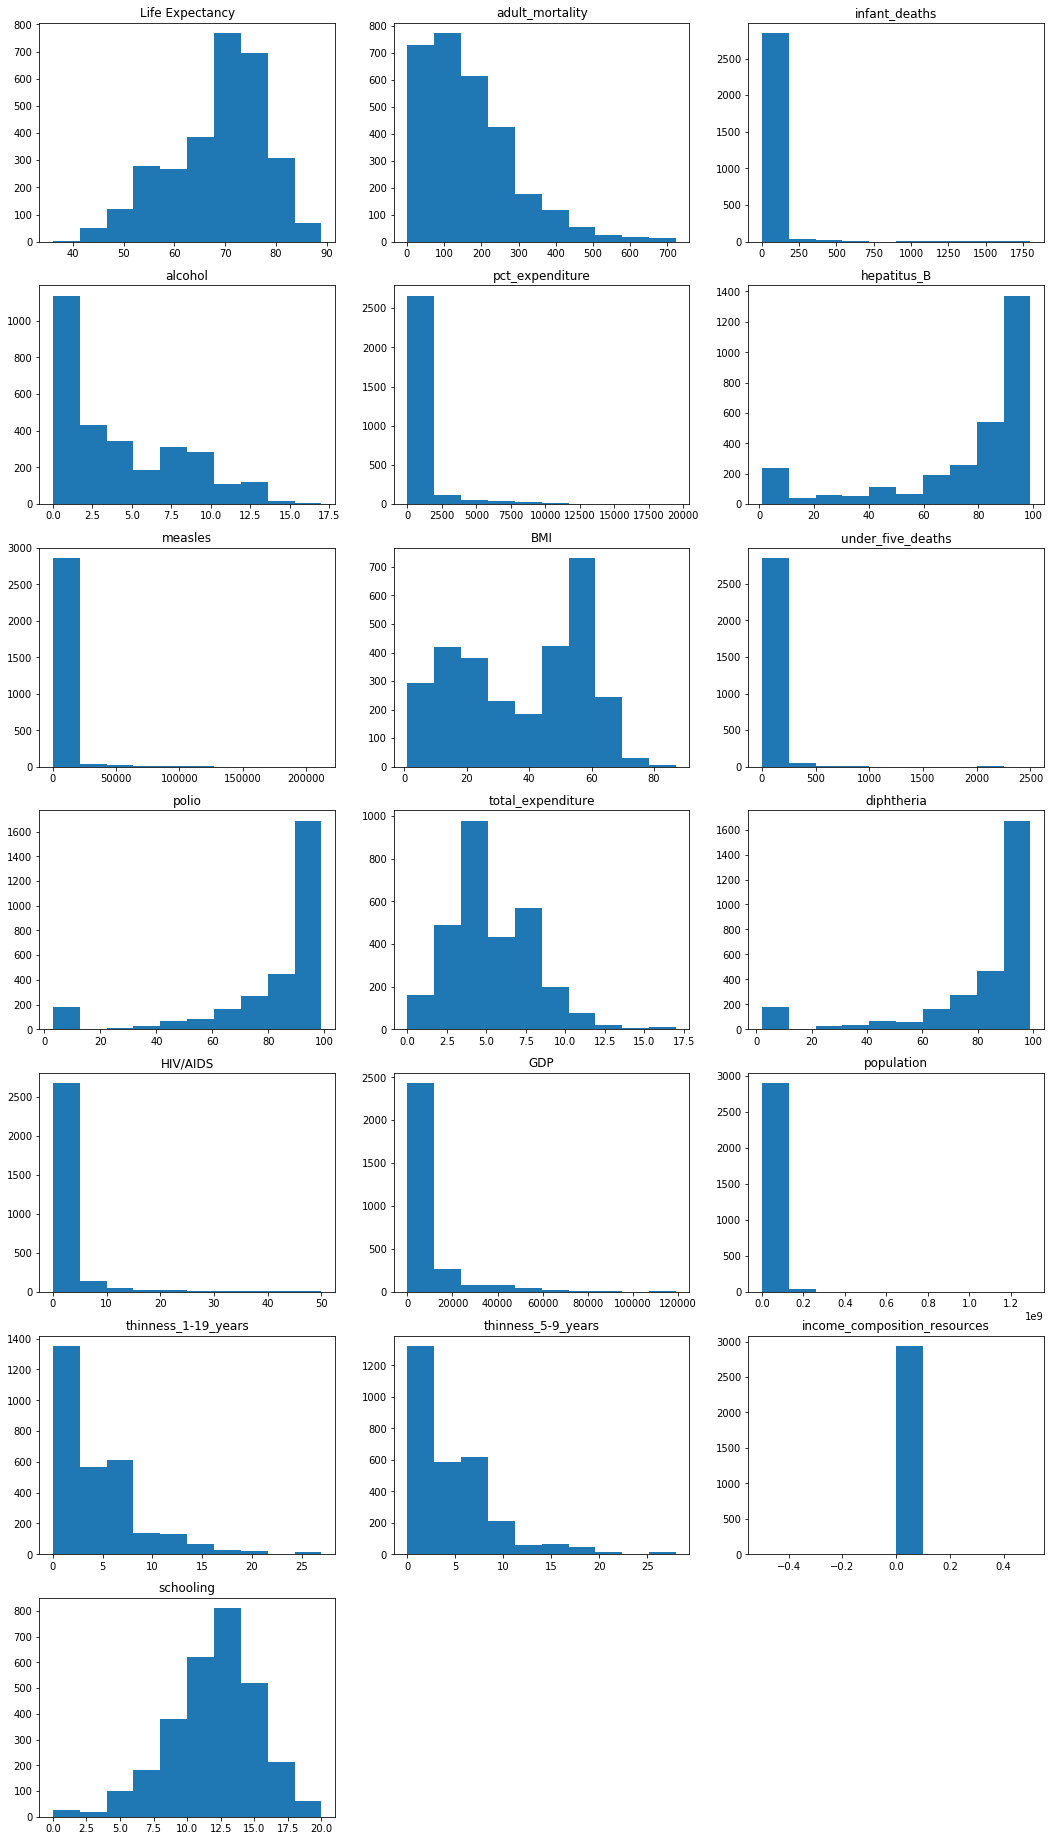

In [21]:
plt.figure(figsize=(18,33))

plt.subplot(7,3,1)
plt.hist(life_expectancy3['life_expectancy'])
plt.title('Life Expectancy')

plt.subplot(7,3,2)
plt.hist(life_expectancy3['adult_mortality'])
plt.title('adult_mortality')

plt.subplot(7,3,3)
plt.hist(life_expectancy3['infant_deaths'])
plt.title('infant_deaths')

plt.subplot(7,3,4)
plt.hist(life_expectancy3['alcohol'])
plt.title('alcohol')

plt.subplot(7,3,5)
plt.hist(life_expectancy3['pct_expenditure'])
plt.title('pct_expenditure')

plt.subplot(7,3,6)
plt.hist(life_expectancy3['hepatitus_B'])
plt.title('hepatitus_B')

plt.subplot(7,3,7)
plt.hist(life_expectancy3['measles'])
plt.title('measles')

plt.subplot(7,3,8)
plt.hist(life_expectancy3['BMI'])
plt.title('BMI')

plt.subplot(7,3,9)
plt.hist(life_expectancy3['under_five_deaths'])
plt.title('under_five_deaths')

plt.subplot(7,3,10)
plt.hist(life_expectancy3['polio'])
plt.title('polio')

plt.subplot(7,3,11)
plt.hist(life_expectancy3['total_expenditure'])
plt.title('total_expenditure')

plt.subplot(7,3,12)
plt.hist(life_expectancy3['diphtheria'])
plt.title('diphtheria')

plt.subplot(7,3,13)
plt.hist(life_expectancy3['HIV/AIDS'])
plt.title('HIV/AIDS')

plt.subplot(7,3,14)
plt.hist(life_expectancy3['GDP'])
plt.title('GDP')

plt.subplot(7,3,15)
plt.hist(life_expectancy3['population'])
plt.title('population')

plt.subplot(7,3,16)
plt.hist(life_expectancy3['thinness_1-19_years'])
plt.title('thinness_1-19_years')

plt.subplot(7,3,17)
plt.hist(life_expectancy3['thinness_5-9_years'])
plt.title('thinness_5-9_years')

plt.subplot(7,3,18)
plt.hist(life_expectancy3['income_composition_resources'])
plt.title('income_composition_resources')

plt.subplot(7,3,19)
plt.hist(life_expectancy3['schooling'])
plt.title('schooling')

plt.show()

#### Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

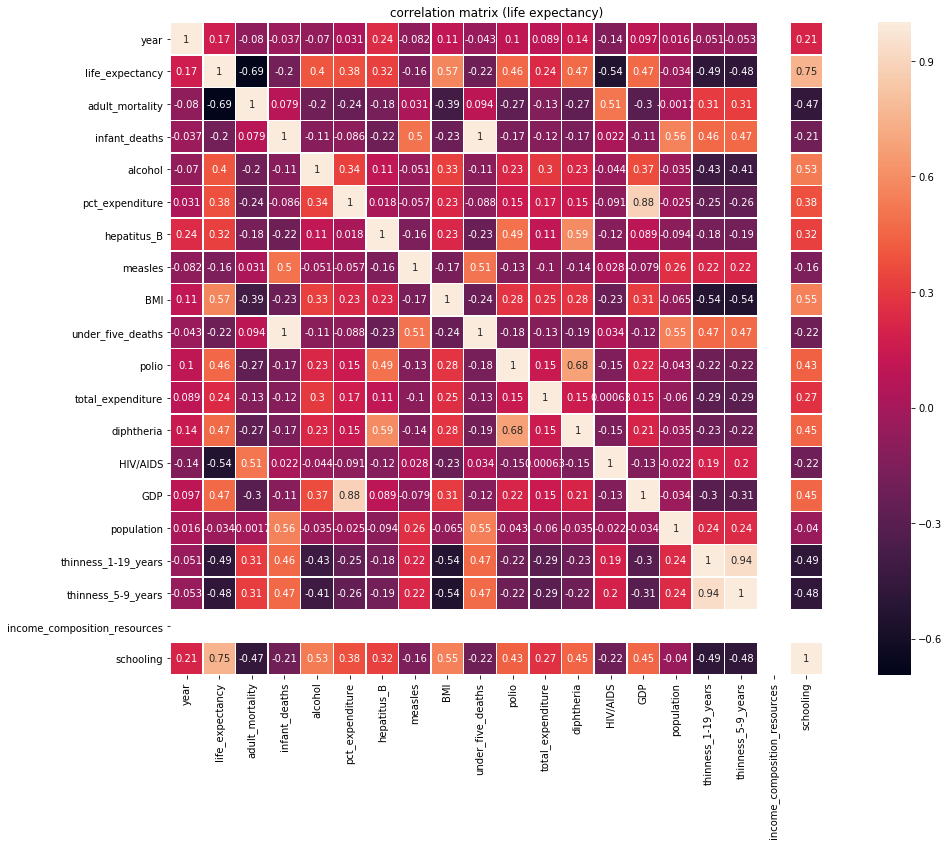

In [22]:
corrmat_life_expectancy = life_expectancy3.corr()

plt.figure(figsize=(20,12))

# draw the heatmap using seaborn.
sns.heatmap(corrmat_life_expectancy, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (life expectancy)")

plt.show()

In [23]:
life_expectancy3.corr()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,pct_expenditure,hepatitus_B,measles,BMI,under_five_deaths,polio,total_expenditure,diphtheria,HIV/AIDS,GDP,population,thinness_1-19_years,thinness_5-9_years,income_composition_resources,schooling
year,1.000000,0.169718,-0.079692,-0.037415,-0.070162,0.031419,0.242228,-0.082493,0.109908,-0.042937,0.102989,0.089345,0.142166,-0.140822,0.096560,0.015868,-0.050599,-0.053145,NaN,0.208132
life_expectancy,0.169718,1.000000,-0.694242,-0.196432,0.404215,0.382591,0.320593,-0.157708,0.570144,-0.222247,0.458571,0.236165,0.473114,-0.538995,0.465814,-0.034227,-0.485556,-0.478807,NaN,0.754096
adult_mortality,-0.079692,-0.694242,1.000000,0.078912,-0.200070,-0.242631,-0.184635,0.031317,-0.393640,0.094299,-0.272400,-0.132343,-0.273515,0.512578,-0.302239,-0.001666,0.310628,0.314358,NaN,-0.467956
infant_deaths,-0.037415,-0.196432,0.078912,1.000000,-0.112289,-0.085617,-0.221392,0.501128,-0.226882,0.996629,-0.166647,-0.123935,-0.171280,0.021645,-0.114788,0.560606,0.464308,0.469750,NaN,-0.207737
alcohol,-0.070162,0.404215,-0.200070,-0.112289,1.000000,0.336652,0.109267,-0.050914,0.329354,-0.109713,0.227320,0.302570,0.226896,-0.044028,0.366466,-0.034956,-0.426805,-0.413375,NaN,0.533010
pct_expenditure,0.031419,0.382591,-0.242631,-0.085617,0.336652,1.000000,0.018135,-0.056598,0.230775,-0.087857,0.148466,0.169536,0.145015,-0.091449,0.881104,-0.024746,-0.254729,-0.258620,NaN,0.381470
hepatitus_B,0.242228,0.320593,-0.184635,-0.221392,0.109267,0.018135,1.000000,-0.155116,0.225620,-0.232449,0.493688,0.113044,0.594222,-0.123071,0.089395,-0.093848,-0.183270,-0.193500,NaN,0.319416
measles,-0.082493,-0.157708,0.031317,0.501128,-0.050914,-0.056598,-0.155116,1.000000,-0.174286,0.507809,-0.132342,-0.102504,-0.138022,0.027812,-0.078607,0.258817,0.222365,0.220157,NaN,-0.157234
BMI,0.109908,0.570144,-0.393640,-0.226882,0.329354,0.230775,0.225620,-0.174286,1.000000,-0.237539,0.281244,0.253794,0.280546,-0.231452,0.305459,-0.065086,-0.535330,-0.542474,NaN,0.551192
under_five_deaths,-0.042937,-0.222247,0.094299,0.996629,-0.109713,-0.087857,-0.232449,0.507809,-0.237539,1.000000,-0.184507,-0.125675,-0.191611,0.033777,-0.118784,0.548111,0.466711,0.470799,NaN,-0.224131


In [24]:
life_expectancy_winz = life_expectancy3.copy()

from scipy import stats
from scipy.stats.mstats import winsorize

for col in life_expectancy_winz.columns: 
     life_expectancy_winz[col] = stats.mstats.winsorize(life_expectancy_winz[col], limits=0.05)

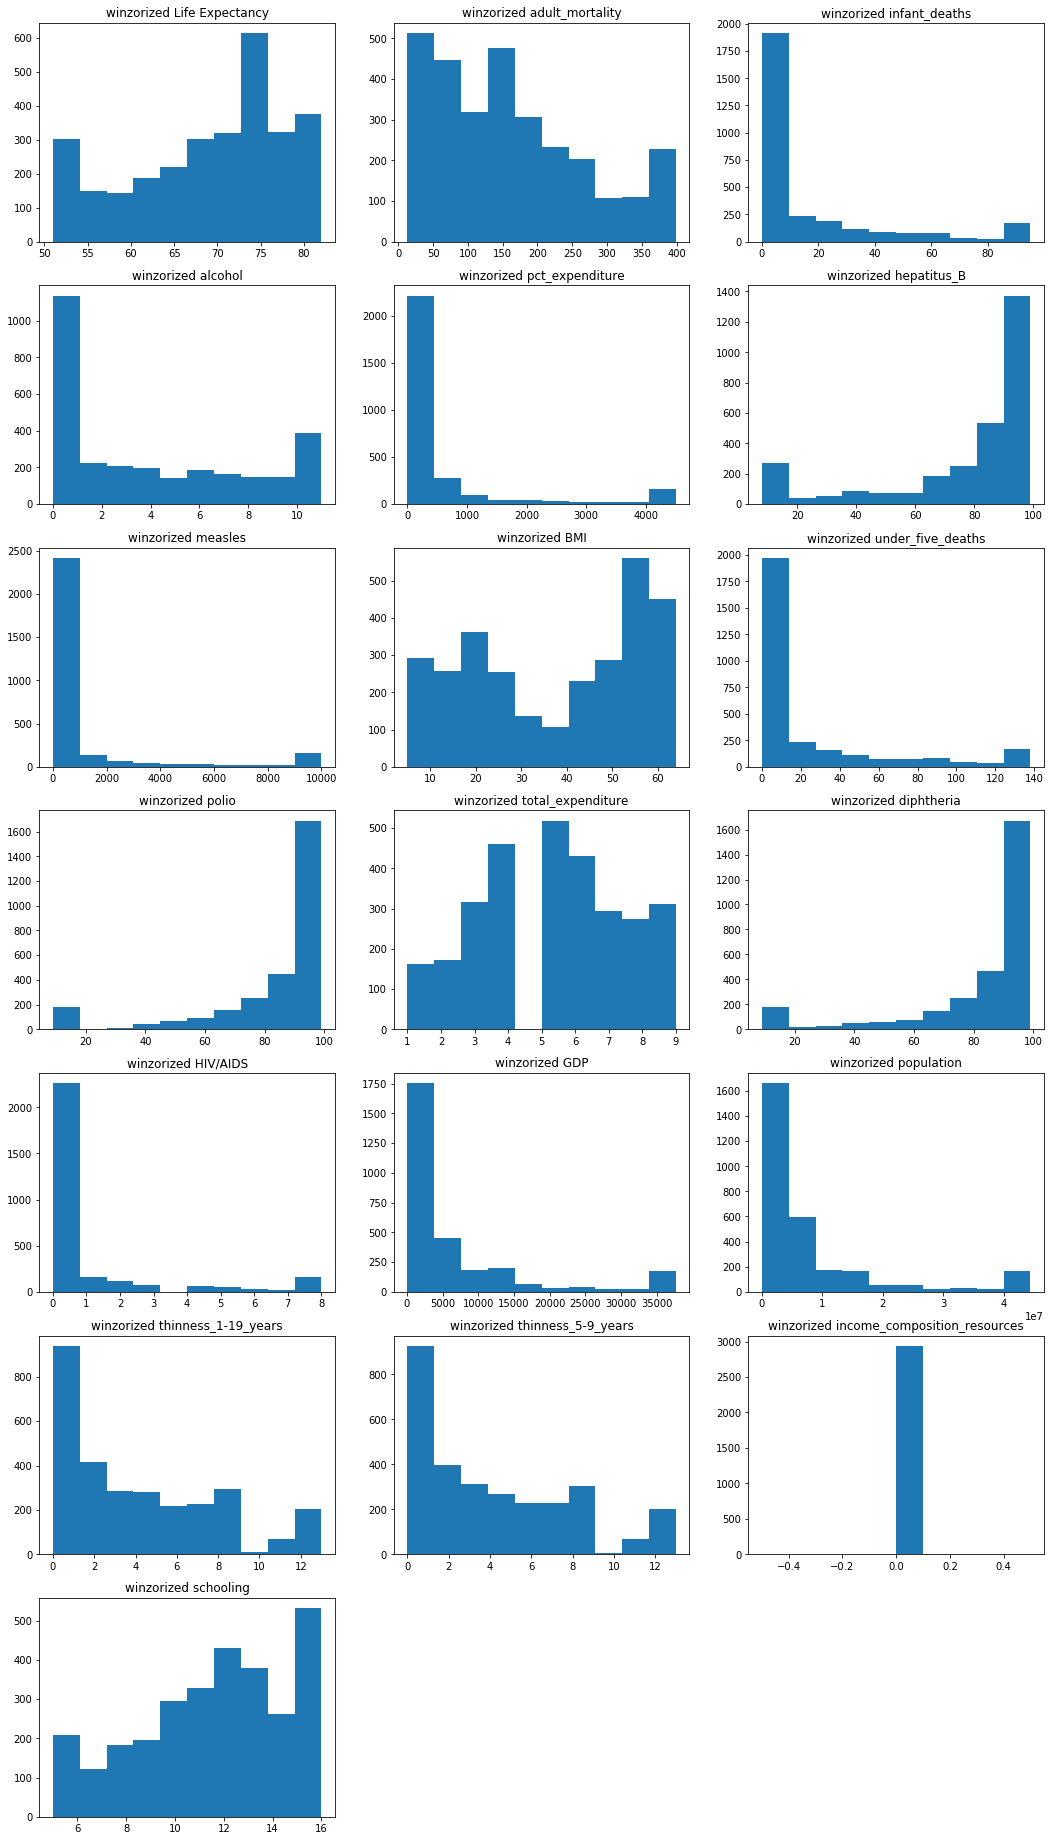

In [25]:
plt.figure(figsize=(18,33))

plt.subplot(7,3,1)
plt.hist(life_expectancy_winz['life_expectancy'])
plt.title('winzorized Life Expectancy')

plt.subplot(7,3,2)
plt.hist(life_expectancy_winz['adult_mortality'])
plt.title('winzorized adult_mortality')

plt.subplot(7,3,3)
plt.hist(life_expectancy_winz['infant_deaths'])
plt.title('winzorized infant_deaths')

plt.subplot(7,3,4)
plt.hist(life_expectancy_winz['alcohol'])
plt.title('winzorized alcohol')

plt.subplot(7,3,5)
plt.hist(life_expectancy_winz['pct_expenditure'])
plt.title('winzorized pct_expenditure')

plt.subplot(7,3,6)
plt.hist(life_expectancy_winz['hepatitus_B'])
plt.title('winzorized hepatitus_B')

plt.subplot(7,3,7)
plt.hist(life_expectancy_winz['measles'])
plt.title('winzorized measles')

plt.subplot(7,3,8)
plt.hist(life_expectancy_winz['BMI'])
plt.title('winzorized BMI')

plt.subplot(7,3,9)
plt.hist(life_expectancy_winz['under_five_deaths'])
plt.title('winzorized under_five_deaths')

plt.subplot(7,3,10)
plt.hist(life_expectancy_winz['polio'])
plt.title('winzorized polio')

plt.subplot(7,3,11)
plt.hist(life_expectancy_winz['total_expenditure'])
plt.title('winzorized total_expenditure')

plt.subplot(7,3,12)
plt.hist(life_expectancy_winz['diphtheria'])
plt.title('winzorized diphtheria')

plt.subplot(7,3,13)
plt.hist(life_expectancy_winz['HIV/AIDS'])
plt.title('winzorized HIV/AIDS')

plt.subplot(7,3,14)
plt.hist(life_expectancy_winz['GDP'])
plt.title('winzorized GDP')

plt.subplot(7,3,15)
plt.hist(life_expectancy_winz['population'])
plt.title('winzorized population')

plt.subplot(7,3,16)
plt.hist(life_expectancy_winz['thinness_1-19_years'])
plt.title('winzorized thinness_1-19_years')

plt.subplot(7,3,17)
plt.hist(life_expectancy_winz['thinness_5-9_years'])
plt.title('winzorized thinness_5-9_years')

plt.subplot(7,3,18)
plt.hist(life_expectancy_winz['income_composition_resources'])
plt.title('winzorized income_composition_resources')

plt.subplot(7,3,19)
plt.hist(life_expectancy_winz['schooling'])
plt.title('winzorized schooling')

plt.show()

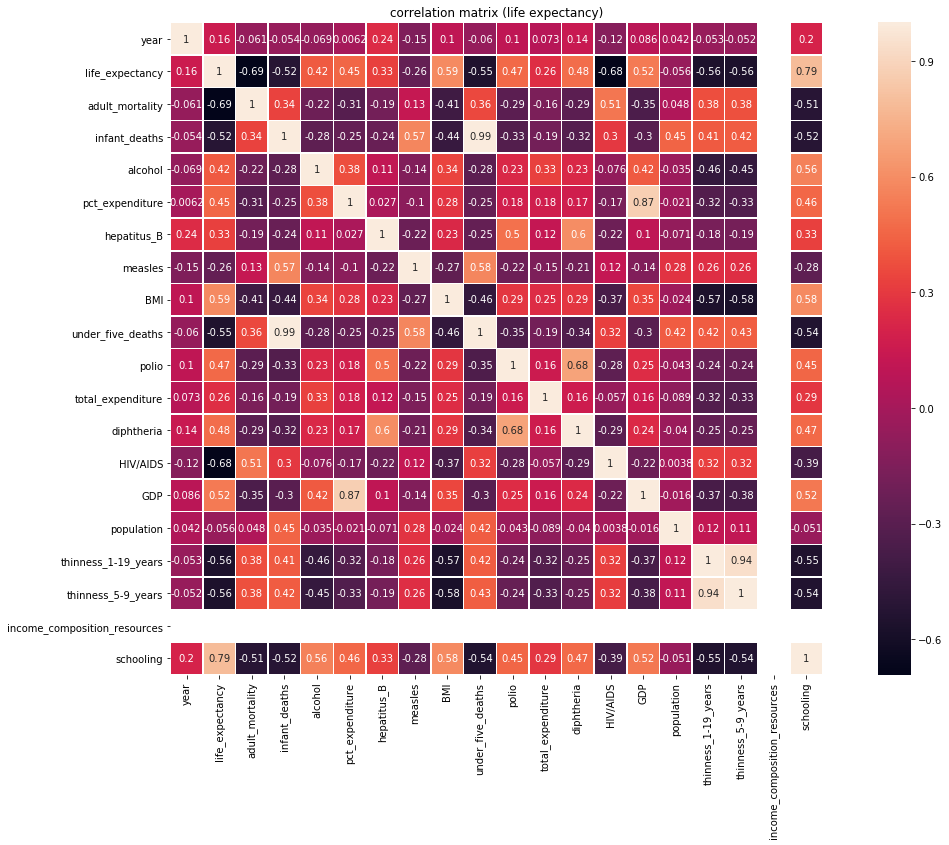

In [26]:
corrmat_life_expectancy = life_expectancy_winz.corr()

plt.figure(figsize=(20,12))

# draw the heatmap using seaborn.
sns.heatmap(corrmat_life_expectancy, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (life expectancy)")

plt.show()

In [27]:
life_expectancy_winz.corr()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,pct_expenditure,hepatitus_B,measles,BMI,under_five_deaths,polio,total_expenditure,diphtheria,HIV/AIDS,GDP,population,thinness_1-19_years,thinness_5-9_years,income_composition_resources,schooling
year,1.000000,0.157423,-0.061006,-0.053808,-0.069091,0.006155,0.242537,-0.149925,0.104231,-0.060349,0.103280,0.072757,0.142407,-0.120118,0.086412,0.041729,-0.052921,-0.052400,NaN,0.203206
life_expectancy,0.157423,1.000000,-0.692371,-0.519154,0.415922,0.452791,0.330243,-0.255562,0.588220,-0.550214,0.466208,0.258904,0.479974,-0.681888,0.524436,-0.055588,-0.560870,-0.560493,NaN,0.793311
adult_mortality,-0.061006,-0.692371,1.000000,0.338773,-0.218174,-0.309008,-0.193529,0.129013,-0.413345,0.355363,-0.290511,-0.160880,-0.293961,0.513694,-0.354343,0.047802,0.375097,0.382612,NaN,-0.510548
infant_deaths,-0.053808,-0.519154,0.338773,1.000000,-0.281598,-0.249911,-0.240796,0.570677,-0.443114,0.993394,-0.325285,-0.190579,-0.316327,0.296478,-0.296669,0.446298,0.414061,0.422520,NaN,-0.515731
alcohol,-0.069091,0.415922,-0.218174,-0.281598,1.000000,0.377600,0.111573,-0.139811,0.341969,-0.282534,0.228913,0.326701,0.227658,-0.076263,0.415367,-0.035238,-0.460336,-0.449798,NaN,0.555597
pct_expenditure,0.006155,0.452791,-0.309008,-0.249911,0.377600,1.000000,0.027273,-0.102334,0.284585,-0.247429,0.183538,0.180250,0.173757,-0.165792,0.872802,-0.021187,-0.324654,-0.332723,NaN,0.459534
hepatitus_B,0.242537,0.330243,-0.193529,-0.240796,0.111573,0.027273,1.000000,-0.223769,0.231250,-0.251499,0.497531,0.124499,0.598407,-0.220040,0.101776,-0.070872,-0.176121,-0.185114,NaN,0.331195
measles,-0.149925,-0.255562,0.129013,0.570677,-0.139811,-0.102334,-0.223769,1.000000,-0.272821,0.576020,-0.218437,-0.150501,-0.206449,0.121852,-0.140621,0.278076,0.255995,0.258096,NaN,-0.278058
BMI,0.104231,0.588220,-0.413345,-0.443114,0.341969,0.284585,0.231250,-0.272821,1.000000,-0.461841,0.288985,0.251388,0.287985,-0.370736,0.350925,-0.024136,-0.566522,-0.576469,NaN,0.583829
under_five_deaths,-0.060349,-0.550214,0.355363,0.993394,-0.282534,-0.247429,-0.251499,0.576020,-0.461841,1.000000,-0.345438,-0.190736,-0.338646,0.320536,-0.298421,0.419465,0.423388,0.427456,NaN,-0.542295


In [28]:
life_expectancy_winz.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,pct_expenditure,hepatitus_B,measles,BMI,under_five_deaths,polio,total_expenditure,diphtheria,HIV/AIDS,GDP,population,thinness_1-19_years,thinness_5-9_years,income_composition_resources,schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.0,2938.000000
mean,2007.518720,68.910143,159.876106,16.453029,4.016678,553.976855,76.362491,1040.621171,37.577604,23.484683,82.392784,5.284207,82.163717,0.936351,6572.728387,7.531028e+06,4.216133,4.219877,0.0,11.496256
std,4.613841,8.930639,109.773477,26.250321,3.811447,1138.447857,27.712573,2534.945340,19.525132,38.567699,23.364550,2.235359,23.638207,2.142291,9856.030223,1.135490e+07,3.758624,3.757546,0.0,2.981069
min,2000.000000,51.000000,13.000000,0.000000,0.000000,0.000000,8.000000,0.000000,5.000000,0.000000,9.000000,1.000000,9.000000,0.000000,75.000000,1.455900e+04,0.000000,0.000000,0.0,5.000000
25%,2004.000000,63.000000,74.000000,0.000000,0.000000,4.000000,68.000000,0.000000,19.000000,0.000000,77.000000,4.000000,78.000000,0.000000,547.000000,3.812700e+05,1.000000,1.000000,0.0,10.000000
50%,2008.000000,72.000000,144.000000,3.000000,3.000000,64.000000,88.000000,17.000000,43.000000,4.000000,93.000000,5.000000,93.000000,0.000000,2351.500000,2.987154e+06,3.000000,3.000000,0.0,12.000000
75%,2012.000000,75.000000,227.000000,22.000000,7.000000,440.750000,96.000000,360.250000,56.000000,28.000000,97.000000,7.000000,97.000000,0.000000,7582.250000,8.357219e+06,7.000000,7.000000,0.0,14.000000
max,2015.000000,82.000000,399.000000,95.000000,11.000000,4508.000000,99.000000,10000.000000,64.000000,138.000000,99.000000,9.000000,99.000000,8.000000,37698.000000,4.439732e+07,13.000000,13.000000,0.0,16.000000


In [29]:
life_expectancy_winz['alcohol'] = life_expectancy_winz.alcohol + .01
life_expectancy_winz['pct_expenditure'] = life_expectancy_winz.pct_expenditure + .01

#### 4. In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

The variables we will investigate will be: alcohol, pct_expenditure, BMI, polio, and GDP. None of our selected variables have correlations with other variables greater than .8 or less than 0. 

In [30]:
life_expectancy_winz['alcohol_std'],_ = stats.boxcox(life_expectancy_winz['alcohol'])
life_expectancy_winz['pct_expenditure_std'],_ = stats.boxcox(life_expectancy_winz['pct_expenditure'])
life_expectancy_winz['bmi_std'],_ = stats.boxcox(life_expectancy_winz['BMI'])
life_expectancy_winz['polio_std'],_ = stats.boxcox(life_expectancy_winz['polio'])
life_expectancy_winz['gdp_std'],_ = stats.boxcox(life_expectancy_winz['GDP'])


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = life_expectancy_winz[['alcohol_std','pct_expenditure_std','bmi_std','polio_std','gdp_std']]
X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=5)
new_df = pd.DataFrame(sklearn_pca.fit_transform(X),columns=['pca_1', 'pca_2', 'pca_3', 'pca_4','pca_5'])
print(sklearn_pca.explained_variance_ratio_)

[0.4612222  0.16664668 0.14650801 0.12930467 0.09631844]


We have now reduced our dimensionality from 21 to 5. Of our 5 newly engineered components, the first component is responsible for 46.1% of the variance observed; the second component is responsible for 16.7% of the variance observed; the third component is responsible for 14.7% of the variance observed; the fourth component is responsible for 12.9% of the observed variance; and the fifth component is responsible for 9.6% of the observed variance.